# Survival analysis for diabetes patients

### Project Details

The current project is a part of the BYOP (bring your own project) excercise within IPBA program from IIM (Indore).

### Project Scope

The current project aims to analyse time on therapy for diabetes patients using advance analysis techniques. The objective is to learn and implement a solution that allows business to look at different scenarios and understand patient behaviour.

### Data

We have created simulated APLD (anonymised patient level data) using python with fields as below.

| Field                     | Description                                                                 |
|:--------------------------|:----------------------------------------------------------------------------|
| claim_id                  | Insurance claim number (unique)                                             |
| patient_id                | Patient unique ID                                                           |
| service_date              | Date when the claim was adjudicated                                         |
| claim_type                | Paid, rejected or reversed claim                                            |
| days_supply               | Number of days drugs was supplied for                                       |
| quantity                  | Quanity (Capsules)                                                          |
| patient_birth_year        | Date of Birth of Patient                                                    |
| gender                    | Gender of Patient                                                           |
| disease_type              | T1: Type I or T2: Type II diabetes                                          |
| ndc                       | Product ID or Unique Drug code                                              |
| drug_name                 | Brand name of the drug                                                      |
| class                     | Category of Drug                                                            |
| sub_class                 | Sub Category of Drug                                                        |
| mode_of_dispensation      | Way drug is dispensed, oral or injectable                                   |
| treatement_hierarchy      | The order in which drugs are generally prescribed as diabetes intensifies   |
| past_medical_history      | Yes or no                                                                   |
| family_history            | Of diabetes, Yes or no                                                      |
| is_there_complication     | Yes or no                                                                   |
| marital_status            | Married, Unmarried                                                          |
| educational_status        | Educated, Uneducated                                                        |
| employee_status           | Employed, Not Employed                                                      |

### dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import pymysql.cursors
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split


# filters
start_dt = '2019-01-01'
end_dt = '2022-12-31'

# working directory
path = r'C:\Users\Ashutosh Gaur\My Drive\edupunk\courses\ipba\byop\analysis\01_synthetic data'
os.chdir(path.replace('\\', '/'))

### import data

In [2]:
apld_ = pd.read_pickle(path+r"\output\df_diabetes_s1.pickle")

In [3]:
# structure
apld_.head(2).T

,0,1
claim_id,517566340,387782725
patient_id,20006,20006
service_date,2021-10-30,2021-12-14
claim_type,pd,pd
days_supply,45,60
quantity,60,15
patient_birth_year,1963,1963
gender,m,m
disease_type,t2,t2
ndc,47152818127,83161652750


### filter relevant data

Data satisfying following conditions
1. Paid claims
3. For patients with type 2 diabetes
2. Within the study date range

In [4]:
apld = apld_[apld_['claim_type'].isin(['pd'])].copy()
apld['service_date'] = pd.to_datetime(apld['service_date'])

# T2D only
apld = apld[apld['disease_type'].isin(['t2'])]

apld = apld[apld['service_date'].between(start_dt, end_dt)]

## Create features

```yaml
tot         : time on therapy (first day supply till last day of supply)
survived    : wether the patient was active or not by end of our study
total_time  : time period of study i.e. 4 years
dc          : days covered (sum(days_supply))
```

### calculate patient age

In [5]:
#take max birth date: as some patients have multiple birth dates
_age = apld.groupby('patient_id').agg({'patient_birth_year': 'max'}).reset_index()
now = datetime.now()
_age['age'] = now.year - _age['patient_birth_year']

### derive tot

In [6]:
apld['drug_supply_next_dt'] = apld['service_date'] + pd.to_timedelta(apld['days_supply'], unit='d')

In [7]:
# patients prospetive first and last date on therapy
_tot = apld.groupby('patient_id').agg({'service_date': 'min', 'drug_supply_next_dt': 'max'}).reset_index().rename(columns={'service_date': 'drug_supply_first_dt', 'drug_supply_next_dt': 'drug_supply_last_dt'})

In [8]:
#no duplicates
_tot['dup'] = _tot.duplicated('patient_id', keep=False)
print(_tot['dup'].value_counts())
del _tot['dup']

False    9027
Name: dup, dtype: int64


In [9]:
# derive tot
_tot['tot'] = (_tot['drug_supply_last_dt'] - _tot['drug_supply_first_dt']).dt.days
_tot['total_time'] = (pd.Timestamp(end_dt) - pd.Timestamp(start_dt)).days

##### Survival assumption

Our assumption is that if a patient does not take medication after the last date of drug supply expires then the patient has `discontinued treatment`. We see that in the study period (2019 to 2022) ~76% patients have discontinued or not stayed on the therapy for the complete period of sudy.

In [10]:
_tot['survived'] = np.where(_tot['drug_supply_last_dt'] <= end_dt, '1', '0')

In [11]:
_tot['survived'].value_counts()

1    6896
0    2131
Name: survived, dtype: int64

In [12]:
_tot['survived'].value_counts(normalize=True)

1    0.76393
0    0.23607
Name: survived, dtype: float64

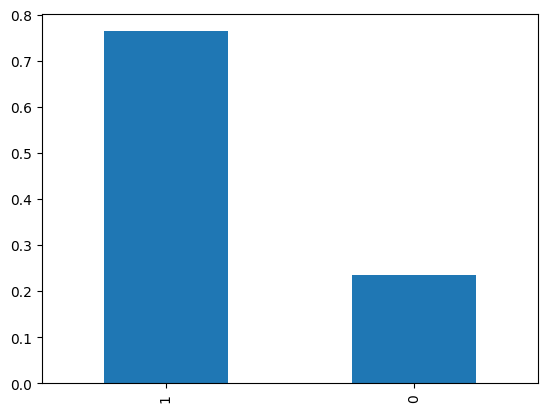

In [13]:
#plot: overall survived
_tot['survived'].value_counts(normalize=True).plot(kind='bar'); plt.show()

#### derive days covered

In [14]:
# days covered
_dc = apld.groupby('patient_id').agg({'days_supply': 'sum'}).reset_index().rename(columns={'days_supply': 'dc'})

In [15]:
# combine
apld = pd.merge(apld, _tot[['patient_id', 'drug_supply_first_dt', 'drug_supply_last_dt', 'tot', 'survived', 'total_time']], on=['patient_id'], how='left')
apld = pd.merge(apld, _dc, on=['patient_id'], how='left')
apld = pd.merge(apld, _age[['patient_id', 'age']], on=['patient_id'], how='left')

## Select features

In [16]:
input = ['patient_id', 'gender', 'age', 'past_medical_history',
         'family_history', 'is_there_complication', 'marital_status',
         'educational_status', 'employee_status', 'tot', 'survived',
         'total_time', 'dc']

df_apld = apld[input].drop_duplicates()
df_apld.head(2).T

,0,20
patient_id,20006,20021
gender,m,f
age,60,62
past_medical_history,y,n
family_history,n,y
is_there_complication,y,y
marital_status,married,single
educational_status,educated,educated
employee_status,unemployed,unemployed
tot,270,112


In [17]:
# duplicates
df_apld['dup'] = df_apld.duplicated('patient_id', keep=False)
df_apld['dup'].value_counts()

False    8761
True      532
Name: dup, dtype: int64

In [18]:
df_apld[df_apld['dup']==True]

# duplicate record: gender, past_medical_history appear in 2 different categories for the same patient
df_apld[df_apld['patient_id'] == 20227].T

,366,384
patient_id,20227,20227
gender,f,m
age,22,22
past_medical_history,n,y
family_history,n,n
is_there_complication,n,y
marital_status,married,single
educational_status,educated,uneducated
employee_status,employee,unemployed
tot,1318,1318


In [19]:
# drop duplicates
dups = df_apld[df_apld['dup'] == 1].sort_values(by=['patient_id'])
df_apld = df_apld[df_apld['dup'] == 0]
del df_apld['dup']

## Explore Data

In [20]:
# patients within last 4 years
l4y = apld[apld['service_date'].between(start_dt, end_dt)][['patient_id']].drop_duplicates()
df_apld_4_yrs = df_apld[df_apld['patient_id'].isin(l4y['patient_id'])].reset_index(drop=True)

In [21]:
# ~75% of the patients in cohort left
df_apld_4_yrs['survived'].value_counts(normalize=True)*100

1    76.829129
0    23.170871
Name: survived, dtype: float64

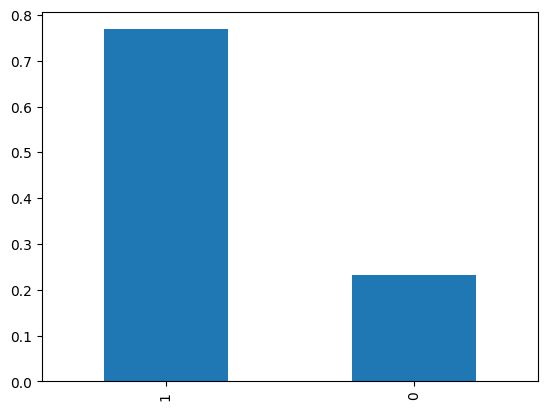

In [22]:
# plot
df_apld_4_yrs['survived'].value_counts(normalize=True).plot(kind='bar'); plt.show()

In [23]:
# summary
df_apld_4_yrs.describe(include=[np.number], percentiles=[.01, .05, .10, .25, .5, .75, .9, .95, .99])


,patient_id,age,tot,total_time,dc
count,8761.000000,8761.000000,8761.000000,8761.0,8761.000000
mean,60434.333295,40.016665,556.623901,1460.0,915.244835
std,23075.599055,20.257153,310.483732,0.0,649.219487
min,20006.000000,5.000000,15.000000,1460.0,15.000000
1%,20792.400000,6.000000,76.600000,1460.0,90.000000
5%,23967.000000,9.000000,155.000000,1460.0,165.000000
10%,28156.000000,12.000000,210.000000,1460.0,240.000000
25%,40781.000000,22.000000,315.000000,1460.0,405.000000
50%,60608.000000,40.000000,489.000000,1460.0,765.000000
75%,80449.000000,58.000000,761.000000,1460.0,1260.000000


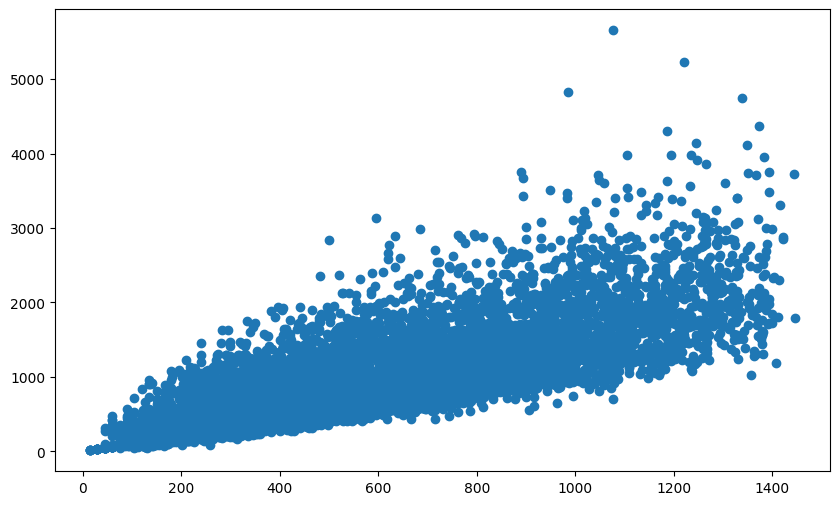

In [24]:
# scatterplot
plt.figure(figsize=(10,6))
plt.scatter(df_apld_4_yrs['tot'], df_apld_4_yrs['dc'])
plt.show()

### Patient time on therapy


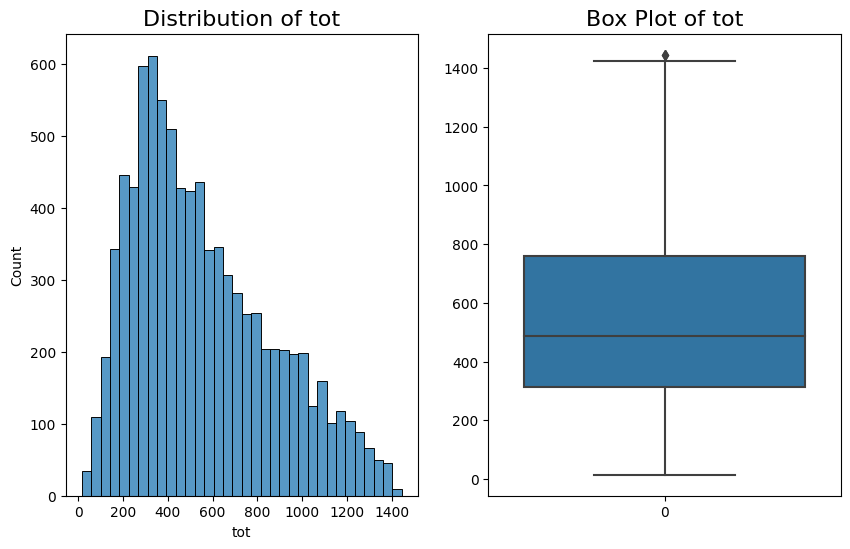

In [25]:
# boxplot & distribution
fig, axes = plt.subplots(1,2,figsize = (10, 6))
axes[0].set_title('Distribution of tot', size=16)
sns.histplot(df_apld_4_yrs['tot'], ax=axes[0])
axes[1].set_title('Box Plot of tot', size=16)
sns.boxplot(df_apld_4_yrs['tot'], ax = axes[1])
plt.show()

## Survival Analysis

Survival anlaysis is a statistical approach to study any system's expected time until it works reliably or time until an event occurs.

In current analysis we are looking at the time when patient last takes their medication signifying their last days on diabetes therapy. The following terms are to be understood in context of the current analysis:

```yaml
Event=1             : The discountinuation of a patients therapy i.e. their last day of drug supply is the event.
Survival time       : Time taken till event or failure occurs or time to failure.
Survival probablity : Probability of an event occurrence after a certain time.
Censor=0            : Some patients continue their journey past the study period i.e. they did not discontinue or did not expeirence the event, they are censored.
Hazard rate         : Opposite of survival time, also known as event rate or death rate or failure rate.
```

<br>

<hr>

Source: https://mathworld.wolfram.com

### Survival function

$$S(t)=P( \ T \ > \ t \ ); \ 0 < t\ < \infty$$

$S(t)$ is the probability distribution of a subject surviving after time $t$ where time ranges from 0 to $\infty$.

Ideally, survival function is represented by a decreasing smooth curve which begins at $S(t) = 1$ and ends at $t = 0$. One important property of survival function is that it is monotonically decreasing.


### Hazard function

The hazard function (also known as the failure rate, hazard rate, or force of mortality) h(x) is the ratio of the probability density function P(x) to the survival function S(x), given by

$$h(x) \ = \ \frac{P(x)}{S(x)}$$

where $D(x)$ is the distribution function.


## Kaplan meier estimate

In [37]:
# patients within last 4 years
l4y = apld[apld['service_date'].between(start_dt, end_dt)][['patient_id']].drop_duplicates()
df_apld_4_yrs = df_apld[df_apld['patient_id'].isin(l4y['patient_id'])].reset_index(drop=True)

In [32]:
# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

### model fit

In [33]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 8761 total observations, 2030 right-censored observations>

### survival probablity

In [34]:
# survival probablity
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
15.0,0.999429
30.0,0.998288
45.0,0.996005
59.0,0.995891
...,...
1415.0,0.064299
1421.0,0.064299
1422.0,0.064299


### km plot

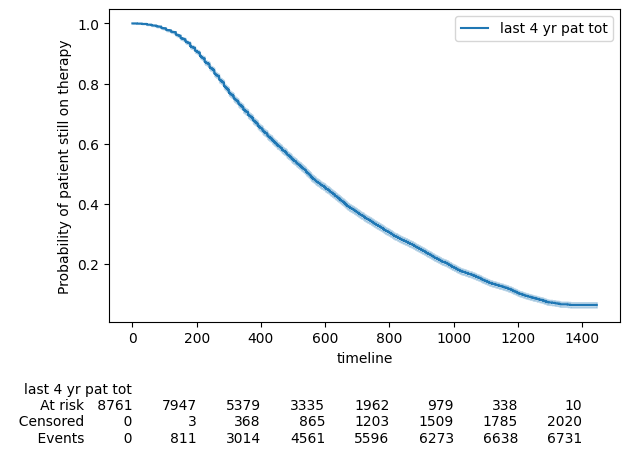

In [49]:
kmf = KaplanMeierFitter().fit(T, E, label="last 4 yr pat tot")
plt.ylabel("Probability of patient still on therapy")
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()
plt.show()

### cumulative_density_

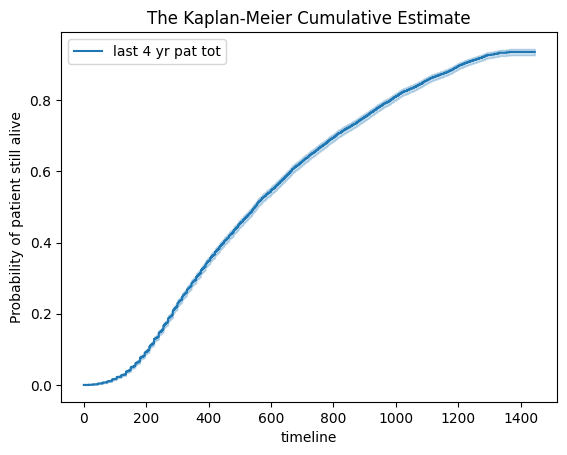

In [50]:
kmf.cumulative_density_
kmf.plot_cumulative_density()
plt.title("The Kaplan-Meier Cumulative Estimate")
plt.ylabel("Probability of patient still alive")
plt.show()

### event table

In [42]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,8761,8761
15.0,5,5,0,0,8761
30.0,10,10,0,0,8756
45.0,20,20,0,0,8746
59.0,1,1,0,0,8726
...,...,...,...,...,...
1415.0,1,0,1,0,5
1421.0,1,0,1,0,4
1422.0,1,0,1,0,3


### plot confidence interval

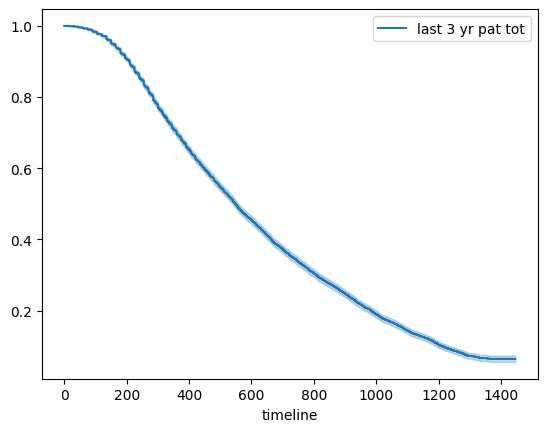

In [43]:
kmf.plot_survival_function()
plt.show()

### median survival time

In [44]:
kmf.median_survival_time_

549.0

### median confidence interval

In [45]:
median_ci = median_survival_times(kmf.confidence_interval_)
median_ci

,last 3 yr pat tot_lower_0.95,last 3 yr pat tot_upper_0.95
0.5,540.0,557.0


### predict

In [47]:
# predict: get survival probablities for unknown time instance
kmf.predict([10, 20, 40, 100, 200, 500, 700, 793, 800, 900, 1000, 1095, 1200, 1500])

10      1.000000
20      0.999429
40      0.998288
100     0.983449
200     0.907430
500     0.546619
700     0.372235
793     0.309271
800     0.304635
900     0.247403
1000    0.189317
1095    0.145756
1200    0.103968
1500    0.064299
Name: last 3 yr pat tot, dtype: float64

### compare kaplan meier models

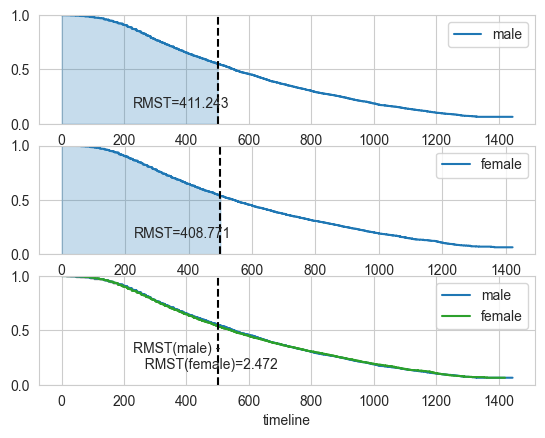

In [128]:
from lifelines.utils import restricted_mean_survival_time
from lifelines import KaplanMeierFitter

# patients within last 4 years
l4y = apld[apld['service_date'].between(start_dt, end_dt)][['patient_id']].drop_duplicates()
df_apld_4_yrs = df_apld[df_apld['patient_id'].isin(l4y['patient_id'])]
df_apld_4_yrs.head(2)

# bins
df_apld_4_yrs['age_bin'] = pd.cut(df_apld_4_yrs['age'], [0, 16, 25, 45, 60, 80])

data = df_apld_4_yrs[['gender', 'tot', 'survived']].reset_index(drop=True)

ix = data['gender'] == 'm'
T, E = data['tot'], data['survived']

time_limit = 500

kmf_male = KaplanMeierFitter().fit(T[ix], E[ix], label='male')
rmst_male = restricted_mean_survival_time(kmf_male, t=time_limit)

kmf_female = KaplanMeierFitter().fit(T[~ix], E[~ix], label='female')
rmst_female = restricted_mean_survival_time(kmf_female, t=time_limit)

#plot
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_male, t=time_limit, ax=ax)

ax = plt.subplot(312)
rmst_plot(kmf_female, t=time_limit, ax=ax)

ax = plt.subplot(313)
rmst_plot(kmf_male, model2=kmf_female, t=time_limit, ax=ax)
plt.show()

## Kaplan meier estimate by gender

In [53]:
# patients within last 4 years
l4y = apld[apld['service_date'].between(start_dt, end_dt)][['patient_id']].drop_duplicates()
df_apld_4_yrs = df_apld[df_apld['patient_id'].isin(l4y['patient_id'])]

df_apld_4_yrs["gender"].value_counts(normalize=True)*100

m    59.901838
f    40.098162
Name: gender, dtype: float64

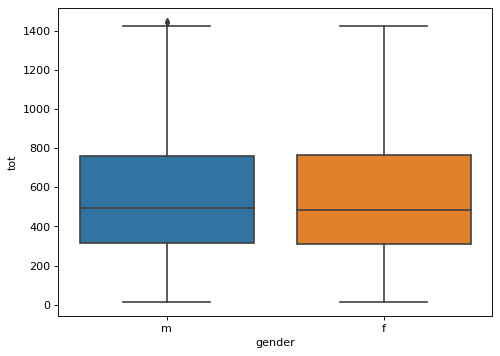

In [58]:
# boxplot
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['gender'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

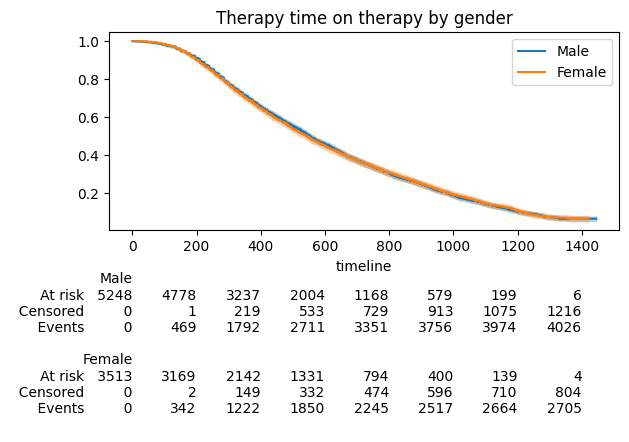

In [60]:
# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

male = (df_apld_4_yrs["gender"] == "m")

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[male], event_observed=E[male], label="Male")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~male], event_observed=E[~male], label="Female")
kmf2.plot_survival_function(ax=ax)

plt.title("Therapy time on therapy by gender")

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [61]:
# logrank_test
results = logrank_test(T[male], T[~male], E[male], E[~male], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.97      0.04

## Kaplan meier estimate by age

In [62]:
# create age bins
df_apld_4_yrs['age_bin'] = pd.cut(df_apld_4_yrs['age'], [0, 16, 25, 45, 60, 80])

# summary
df_apld_4_yrs['age_bin'].value_counts()

(25, 45]    2474
(45, 60]    1869
(60, 80]    1804
(0, 16]     1408
(16, 25]    1206
Name: age_bin, dtype: int64

In [64]:
# summary %
df_apld_4_yrs['age_bin'].value_counts(normalize=True)*100

(25, 45]    28.238786
(45, 60]    21.333181
(60, 80]    20.591257
(0, 16]     16.071225
(16, 25]    13.765552
Name: age_bin, dtype: float64

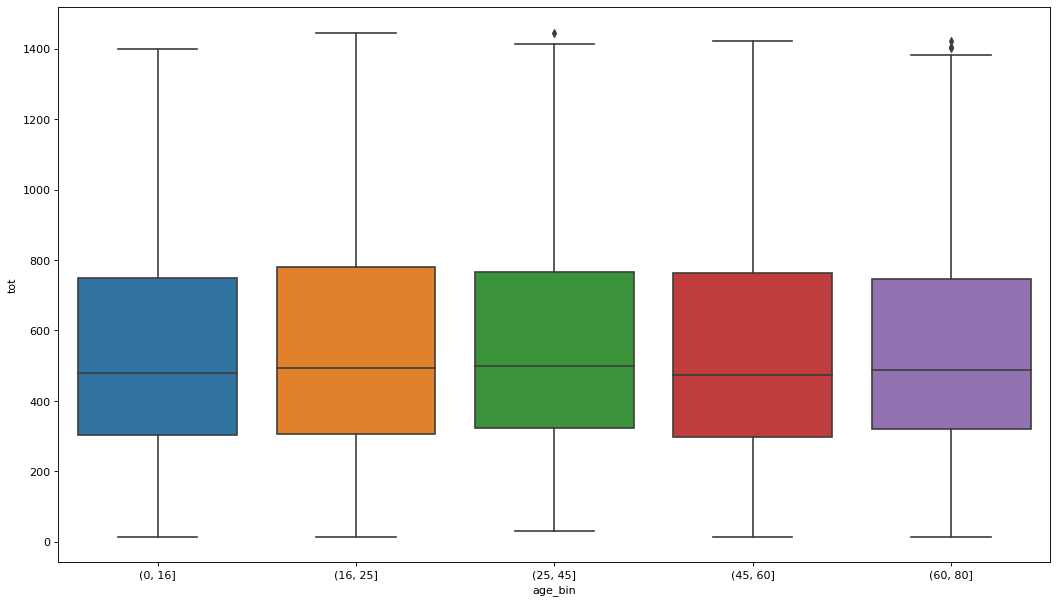

In [65]:
# boxplot
plt.figure(figsize=(16,9), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['age_bin'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

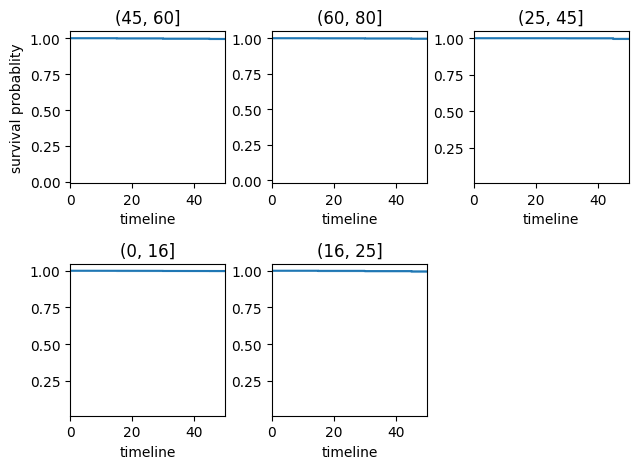

In [66]:
# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

age_bins = df_apld_4_yrs['age_bin'].unique()

# km plots
for i, age_bin in enumerate(age_bins):
    ax = plt.subplot(2, 3, i + 1)
    ix = df_apld_4_yrs['age_bin'] == age_bin
    kmf.fit(T[ix], E[ix], label=age_bin)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(age_bin)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('survival probablity')

plt.tight_layout()
plt.show()

## Kaplan meier estimate by past_medical_history

In [68]:
# ~28 patients with past medical history
df_apld_4_yrs["past_medical_history"].value_counts(normalize=True)*100

n    71.692729
y    28.307271
Name: past_medical_history, dtype: float64

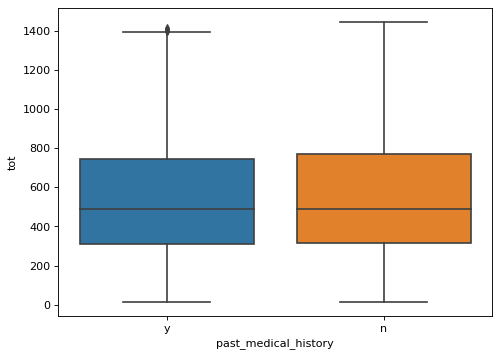

In [70]:
# boxplot
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['past_medical_history'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

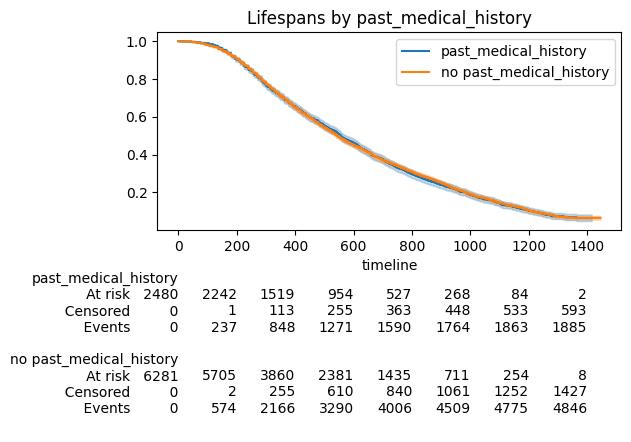

In [71]:
# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

past_medical_history = (df_apld_4_yrs["past_medical_history"] == "y")

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[past_medical_history], event_observed=E[past_medical_history], label="past_medical_history")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~past_medical_history], event_observed=E[~past_medical_history], label="no past_medical_history")
kmf2.plot_survival_function(ax=ax)

plt.title("time on therapy by past_medical_history");

add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [72]:
# logrank_test
results = logrank_test(T[past_medical_history], T[~past_medical_history], E[past_medical_history], E[~past_medical_history], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.29 0.26      1.97

## Kaplan meier estimate by family_history

In [75]:
# ~19 patients with past medical history
df_apld_4_yrs["family_history"].value_counts(normalize=True)*100

n    80.572994
y    19.427006
Name: family_history, dtype: float64

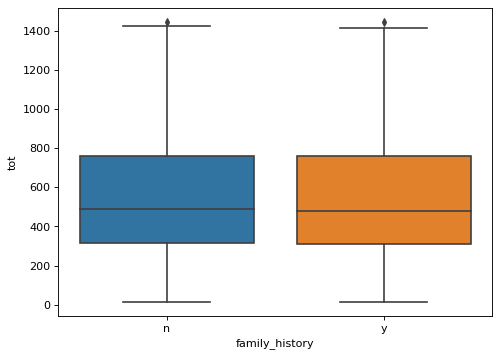

In [77]:
# boxplot
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['family_history'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

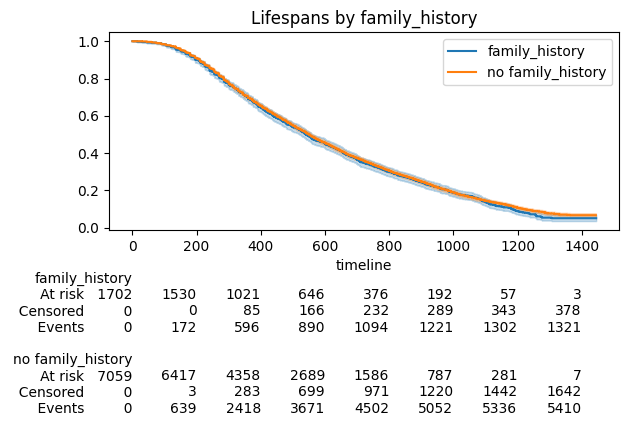

In [78]:
# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

family_history = (df_apld_4_yrs["family_history"] == "y")

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[family_history], event_observed=E[family_history], label="family_history")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~family_history], event_observed=E[~family_history], label="no family_history")
kmf2.plot_survival_function(ax=ax)

plt.title("time on therapy by family_history")

add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [79]:
# logrank_test
results = logrank_test(T[family_history], T[~family_history], E[family_history], E[~family_history], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

## Kaplan meier estimate by is_there_complication

In [81]:
# ~32 patients with complications
df_apld_4_yrs["is_there_complication"].value_counts(normalize=True)*100

y    67.047141
n    32.952859
Name: is_there_complication, dtype: float64

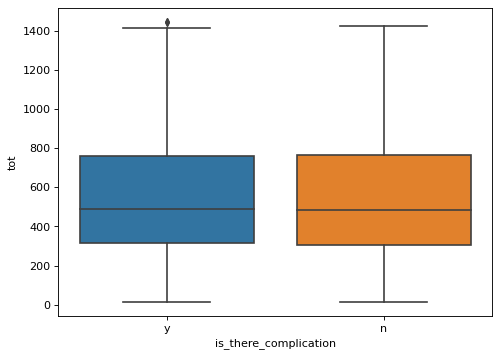

In [82]:
# boxplot
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['is_there_complication'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

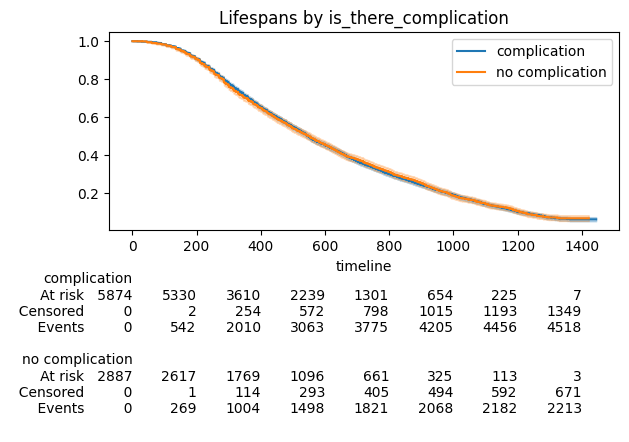

In [83]:
# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

is_there_complication = (df_apld_4_yrs["is_there_complication"] == "y")

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[is_there_complication], event_observed=E[is_there_complication], label="complication")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~is_there_complication], event_observed=E[~is_there_complication], label="no complication")
kmf2.plot_survival_function(ax=ax)

plt.title("time on therapy by is_there_complication")

add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [84]:
# logrank_test
results = logrank_test(T[is_there_complication], T[~is_there_complication], E[is_there_complication], E[~is_there_complication], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.88      0.18

## Kaplan meier estimate by marital_status

In [86]:
# ~62% patients are married
df_apld_4_yrs["marital_status"].value_counts(normalize=True)*100

married    62.412967
single     37.587033
Name: marital_status, dtype: float64

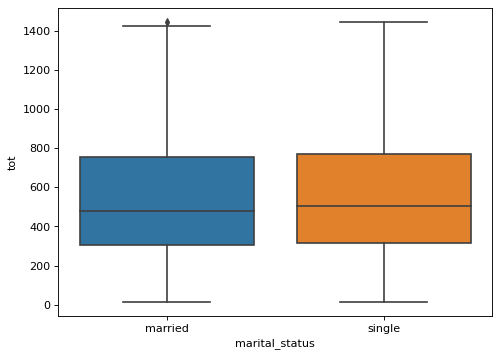

In [88]:
# boxplot: not much difference
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['marital_status'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

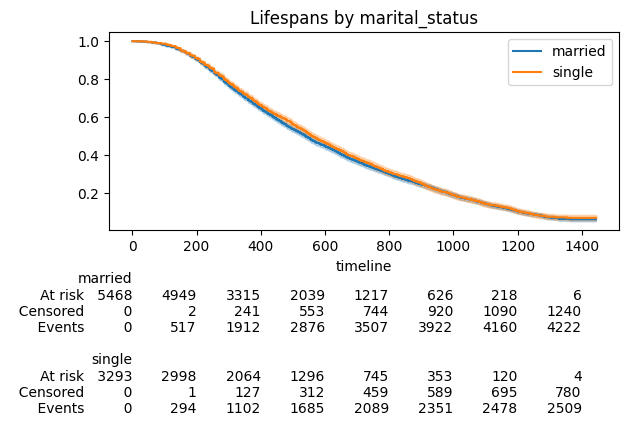

In [89]:
marital_status = (df_apld_4_yrs["marital_status"] == "married")

# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[marital_status], event_observed=E[marital_status], label="married")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~marital_status], event_observed=E[~marital_status], label="single")
kmf2.plot_survival_function(ax=ax)

plt.title("time on therapy by marital_status")

add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [90]:
# logrank_test
results = logrank_test(T[marital_status], T[~marital_status], E[marital_status], E[~marital_status], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.76 0.38      1.39

## Kaplan meier estimate by educational_status

In [92]:
# ~76% patients are educated
df_apld_4_yrs["educational_status"].value_counts(normalize=True)*100

educated      76.189933
uneducated    23.810067
Name: educational_status, dtype: float64

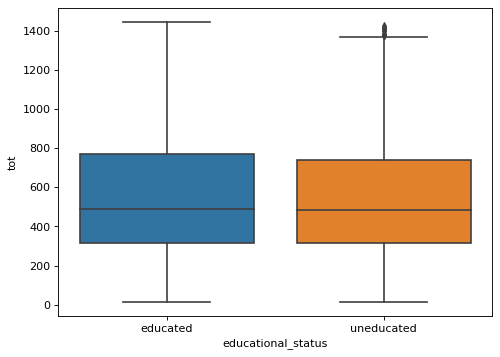

In [93]:
# boxplot
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['educational_status'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

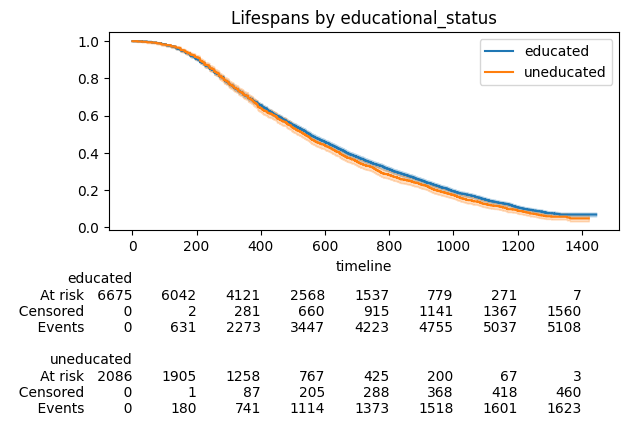

In [94]:
educational_status = (df_apld_4_yrs["educational_status"] == "educated")

# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[educational_status], event_observed=E[educational_status], label="educated")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~educational_status], event_observed=E[~educational_status], label="uneducated")
kmf2.plot_survival_function(ax=ax)

plt.title("time on therapy by educational_status");

add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [95]:
# logrank_test
results = logrank_test(T[educational_status], T[~educational_status], E[educational_status], E[~educational_status], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.13 0.02      5.41

## Kaplan meier estimate by employee_status

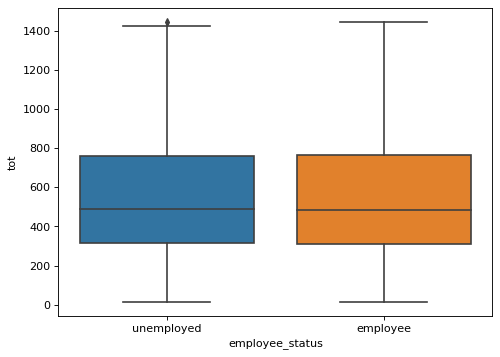

In [96]:
# boxplot
plt.figure(figsize=(7,5), dpi= 80)
sns.boxplot(x=df_apld_4_yrs['employee_status'], y=df_apld['tot'], data=df_apld_4_yrs, notch=False)
plt.show()

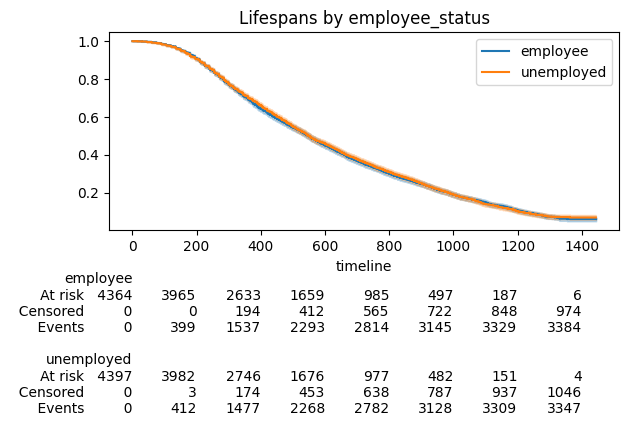

In [97]:
employee_status = (df_apld_4_yrs["employee_status"] == "employee")

# select variables to model
T = df_apld_4_yrs["tot"]
E = df_apld_4_yrs["survived"]

ax = plt.subplot(111)

kmf1 = KaplanMeierFitter()
kmf1.fit(T[employee_status], event_observed=E[employee_status], label="employee")
kmf1.plot_survival_function(ax=ax)

kmf2 = KaplanMeierFitter()
kmf2.fit(T[~employee_status], event_observed=E[~employee_status], label="unemployed")
kmf2.plot_survival_function(ax=ax)

plt.title("Lifespans by employee_status");

add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

plt.show()

In [98]:
# logrank_test
results = logrank_test(T[employee_status], T[~employee_status], E[employee_status], E[~employee_status], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.19 0.66      0.59

## Cox proportional hazard rate

Often we have additional data aside from the duration that we want to use. The technique is called survival regression – the name implies we regress covariates (e.g., age, country, etc.) against another variable – in this case durations.

$$h(t|x) = b_0(t)\exp{\sum_{i=1}^{n} b_i(x_i)}$$

t represents the survival time, the hazard may vary over time

$h(t)$ is the hazard function determined by a set of n covariates (x1,x2,...,xn)

$b_0(t)$  is the baseline hazard function and it is defined as the probability of experiencing the event of interest when all other covariates equal zero. the value of the hazard if all the $x_i$ are equal to zero (the quantity exp(0) equals 1). It is the only time-dependent component in the model. The model makes no assumption about the baseline hazard function and assumes a parametric form for the effect of the covariates on the hazard

$$\exp{\sum_{i=1}^{n} b_i(x_i)}$$ is the partial hazard is a time-invariant scalar factor that only increases or decreases the baseline hazard. It is similar to the intercept in ordinary regression. The covariates or the regression coefficients x give the proportional change that can be expected in the hazard

the coefficients (b1,b2,...,bn) measure the impact (i.e., the effect size) of covariates

There are three assumptions made by the Cox Model:

- The Hazard Ratio of two subjects remains the same at all times.
- The Explanatory Variables act multiplicatively on the Hazard Function.
- Failure times of individual subjects are independent of each other.

Fitting the Cox model to the data involves using iterative methods.

In [100]:
# patients within last 4 years
l4y = apld[apld['service_date'].between(start_dt, end_dt)][['patient_id']].drop_duplicates()
df_apld_4_yrs = df_apld[df_apld['patient_id'].isin(l4y['patient_id'])]
df_apld_4_yrs.head(2).T

,0,20
patient_id,20006,20021
gender,m,f
age,60,62
past_medical_history,y,n
family_history,n,y
is_there_complication,y,y
marital_status,married,single
educational_status,educated,educated
employee_status,unemployed,unemployed
tot,270,112


In [102]:
# bins
df_apld_4_yrs['age_bin'] = pd.cut(df_apld_4_yrs['age'], [0, 16, 25, 45, 60, 80])

data = df_apld_4_yrs[['gender', 'age_bin', 'past_medical_history', 'family_history',
                        'is_there_complication', 'marital_status', 'educational_status',
                        'employee_status', 'tot', 'survived']].reset_index(drop=True)

### label encoding relevant fields

In [103]:
for i in ['gender', 'age_bin', 'past_medical_history', 'family_history',
            'is_there_complication', 'marital_status', 'educational_status',
            'employee_status']:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i].astype(str))

### compare survival population

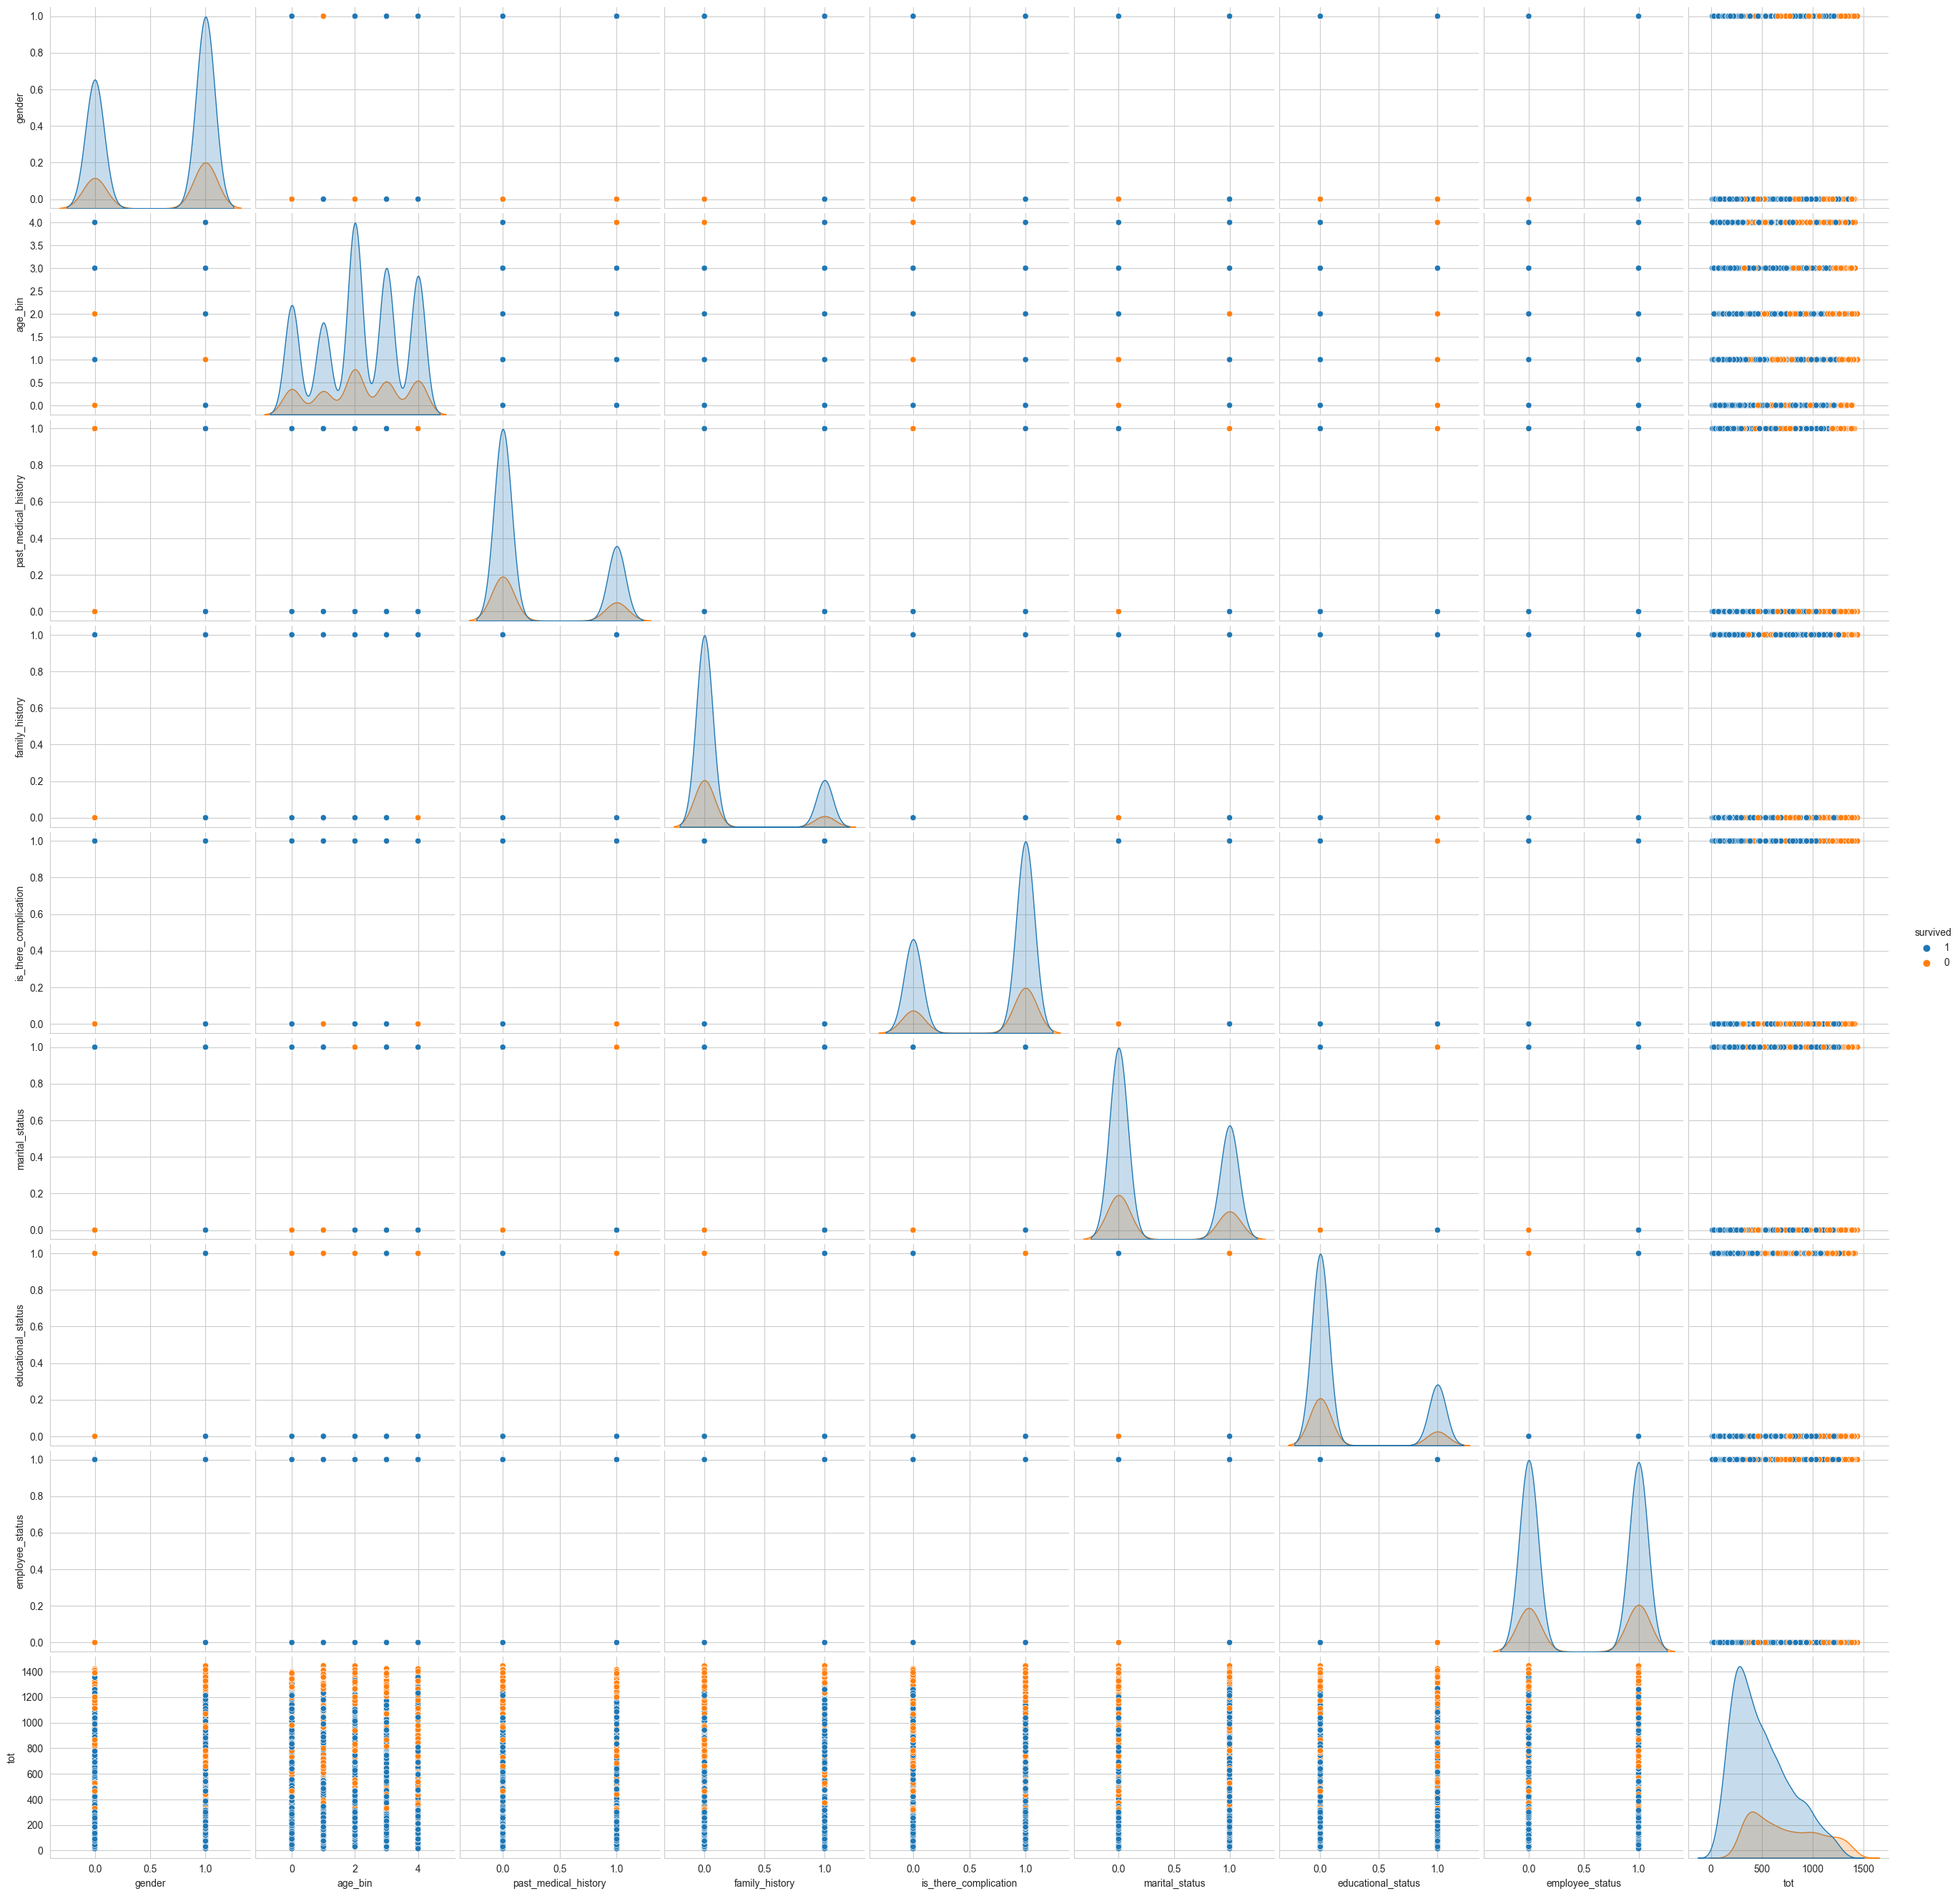

In [106]:
sns.set_style('whitegrid')
sns.pairplot(data,hue='survived',height=3)
plt.show()

### correlation matrix

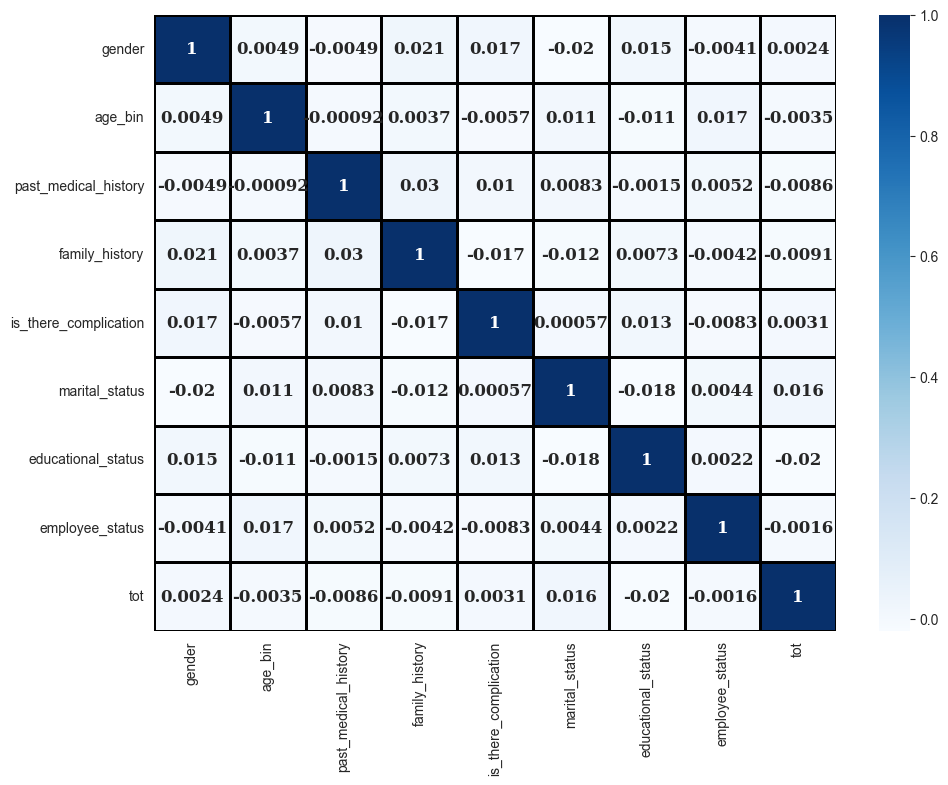

In [109]:
plt.figure(figsize=(11,8))
corr = data.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap='Blues', annot=True,
           annot_kws = {
               'fontsize' : 12, 
               'fontweight' : 'bold',
               'fontfamily' : 'serif'
           },
           linewidth = 1, linecolor = 'black'
           )
plt.show()

### model

<lifelines.CoxPHFitter: fitted with 8761 total observations, 0 right-censored observations>
             duration col = 'tot'
                event col = 'survived'
      baseline estimation = breslow
   number of observations = 8761
number of events observed = 8761
   partial log-likelihood = -70773.04
         time fit was run = 2023-03-30 11:33:44 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
gender                 -0.00       1.00       0.02            -0.05             0.04                 0.96                 1.04
age_bin                 0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
past_medical_history    0.03       1.03       0.02            -0.02             0.07                 0.98                 1.07
family_history          0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08
is_there_complication  -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
marital_status         -0.02       0.98       0.02            -0.06             0.02                 0.94                 1.03
educational_status      0.06       1.06       0.03             0.01             0.11                 1.01                 1.11
employee_status         0.01       1.01       0.02            -0.03             0.05                 0.97                 1.05

                        cmp to     z    p   -log2(p)
covariate                                           
gender                    0.00 -0.13 0.90       0.16
age_bin                   0.00  0.86 0.39       1.36
past_medical_history      0.00  1.07 0.29       1.81
family_history            0.00  0.88 0.38       1.41
is_there_complication     0.00 -0.17 0.86       0.21
marital_status            0.00 -0.83 0.40       1.31
educational_status        0.00  2.24 0.03       5.32
employee_status           0.00  0.41 0.68       0.56
---
Concordance = 0.51
Partial AIC = 141562.09
log-likelihood ratio test = 8.69 on 8 df
-log2(p) of ll-ratio test = 1.44

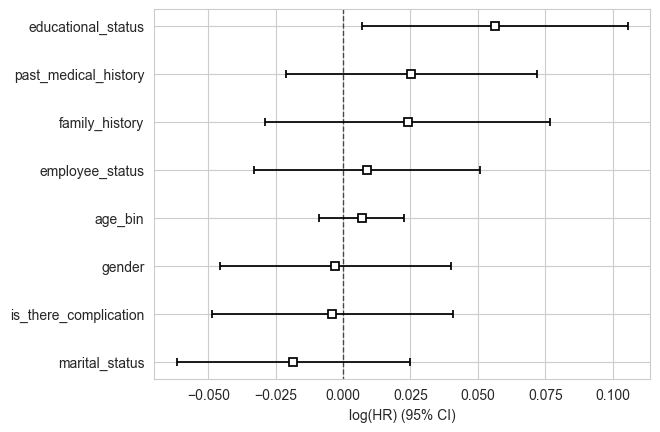

In [115]:
# Cox regression
cph = CoxPHFitter()
cph.fit(data, duration_col='tot', event_col='survived')
cph.print_summary()
cph.plot()
plt.show() #plotting the coefficients

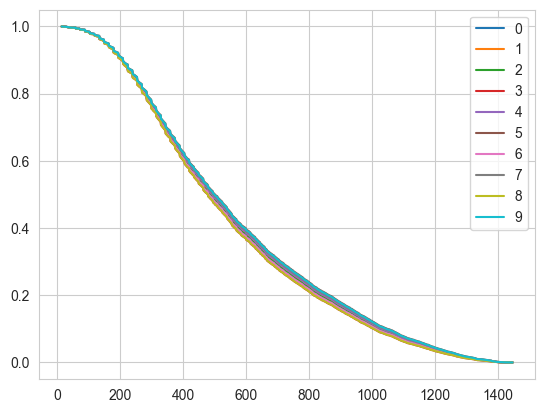

In [112]:
# plot survival function for individual patients
d_data = data.iloc[0:10,:]
cph.predict_survival_function(d_data).plot()
plt.show()

### model selected variable relationship

In [116]:
cph.fit(data, duration_col='tot', event_col='survived', formula="gender + age_bin + is_there_complication + gender*age_bin")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8761 total observations, 0 right-censored observations>
             duration col = 'tot'
                event col = 'survived'
      baseline estimation = breslow
   number of observations = 8761
number of events observed = 8761
   partial log-likelihood = -70776.99
         time fit was run = 2023-03-30 11:34:47 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age_bin                 0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
gender                 -0.01       0.99       0.04            -0.10             0.07                 0.91                 1.07
is_there_complication  -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
age_bin:gender          0.01       1.01       0.02            -0.03             0.04                 0.97                 1.04

                        cmp to     z    p   -log2(p)
covariate                                           
age_bin                   0.00  0.24 0.81       0.30
gender                    0.00 -0.32 0.75       0.42
is_there_complication     0.00 -0.12 0.90       0.15
age_bin:gender            0.00  0.36 0.72       0.47
---
Concordance = 0.50
Partial AIC = 141561.97
log-likelihood ratio test = 0.80 on 4 df
-log2(p) of ll-ratio test = 0.09

### Plotting the effect of varying a covariate

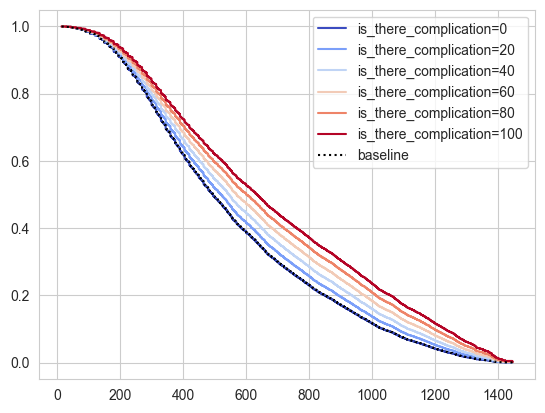

In [120]:
cph = CoxPHFitter()
cph.fit(data, duration_col='tot', event_col='survived')

cph.plot_partial_effects_on_outcome(covariates='is_there_complication', values=[0, 20, 40, 60, 80, 100], cmap='coolwarm')
plt.show()

### Clusters & correlations

In [121]:
cph = CoxPHFitter()
cph.fit(data, duration_col='tot', event_col='survived', cluster_col='gender')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8761 total observations, 0 right-censored observations>
             duration col = 'tot'
                event col = 'survived'
              cluster col = 'gender'
          robust variance = True
      baseline estimation = breslow
   number of observations = 8761
number of events observed = 8761
   partial log-likelihood = -70773.05
         time fit was run = 2023-03-30 11:39:21 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age_bin                 0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
past_medical_history    0.03       1.03       0.02            -0.02             0.07                 0.98                 1.07
family_history          0.02       1.02       0.02            -0.02             0.06                 0.98                 1.07
is_there_complication  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
marital_status         -0.02       0.98       0.03            -0.08             0.05                 0.92                 1.05
educational_status      0.06       1.06       0.01             0.04             0.07                 1.04                 1.07
employee_status         0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02

                        cmp to     z      p   -log2(p)
covariate                                             
age_bin                   0.00  3.98 <0.005      13.85
past_medical_history      0.00  1.12   0.26       1.93
family_history            0.00  1.16   0.25       2.02
is_there_complication     0.00 -0.40   0.69       0.54
marital_status            0.00 -0.55   0.58       0.78
educational_status        0.00  7.02 <0.005      38.69
employee_status           0.00  1.18   0.24       2.07
---
Concordance = 0.51
Partial AIC = 141560.10
log-likelihood ratio test = 8.67 on 7 df
-log2(p) of ll-ratio test = 1.85

### Compare cph models between population groups

In [122]:
# patients within last 4 years
l4y = apld[apld['service_date'].between(start_dt, end_dt)][['patient_id']].drop_duplicates()
df_apld_4_yrs = df_apld[df_apld['patient_id'].isin(l4y['patient_id'])]
df_apld_4_yrs.head(2)

# bins
df_apld_4_yrs['age_bin'] = pd.cut(df_apld_4_yrs['age'], [0, 16, 25, 45, 60, 80])

data = df_apld_4_yrs[['gender', 'age_bin', 'past_medical_history', 'family_history',
                        'is_there_complication', 'marital_status', 'educational_status',
                        'employee_status', 'tot', 'survived']].reset_index(drop=True)

# label encoding relevant fields
for i in ['gender', 'age_bin', 'past_medical_history', 'family_history',
            'is_there_complication', 'marital_status', 'educational_status',
            'employee_status']:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i].astype(str))

# split data
train, test = train_test_split(data)

cph_1 = CoxPHFitter(penalizer=0.1, l1_ratio=0.).fit(train, 'tot', 'survived')
cph_2 = CoxPHFitter(penalizer=0.1, l1_ratio=1.).fit(train, 'tot', 'survived')

In [123]:
# Log-likelihood
print(cph_1.score(test))
print(cph_2.score(test))

-6.6960859114021725
-6.694288169962778


In [124]:
# Akaike information criterion (AIC)
print(cph_1.AIC_partial_) #lower is better
print(cph_2.AIC_partial_)

102380.42215234652
102390.7688932916


In [125]:
# Concordance Index
print(cph_1.concordance_index_)
print(cph_2.concordance_index_)

0.5094571130476929
0.5096908124450366


### Selecting a parametric model using QQ plots

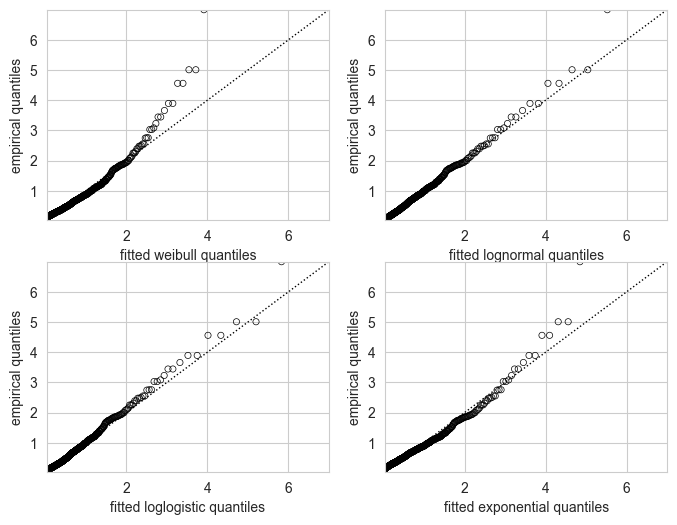

In [131]:
from lifelines import *
from lifelines.plotting import qq_plot
import matplotlib.pyplot as plt

#simulate some fake log-normal data
N = 1000
T_actual = np.exp(np.random.randn(N))
C = np.exp(np.random.randn(N))
E = T_actual < C
T = np.minimum(T_actual, C)

#this graphical test can be used to invalidate models. For example, in the above figure, we can see that only the log-normal parametric model is appropriate (we expect deviance in the tails, but not too much). Another use case is choosing the correct parametric AFT model.
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])
#save_viz_to_misc_folder('ml.survival analysis/survival_parametric_model_selection.png')
plt.show()

### Selecting a parametric model using AIC

<lifelines.SplineFitter:"SplineFitter: 3 internal knot", fitted with 8761 total observations, 2030 right-censored observations>
99565.72856511982


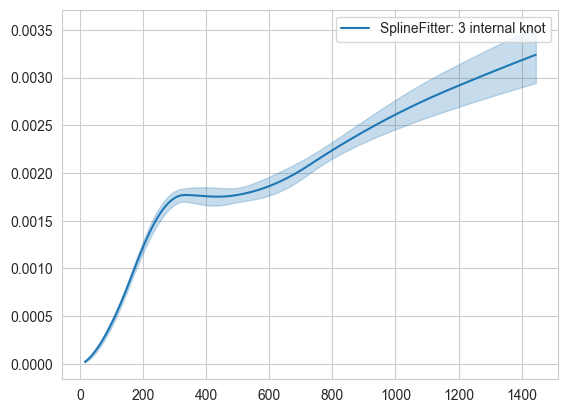

In [129]:
from lifelines.utils import find_best_parametric_model
from lifelines.datasets import load_lymph_node

best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")

print(best_model)
print(best_aic_)

best_model.plot_hazard()
plt.show()